In [25]:
source('./utils.r')
data = get_country_data('france')

[1] "Check dependencies..."


Warning message:
“17567 parsing failures.
row       col expected actual                      file
  1 gaz_cogen a number     ND './_data/france/2012.csv'
  4 gaz_cogen a number     ND './_data/france/2012.csv'
  6 gaz_cogen a number     ND './_data/france/2012.csv'
 10 gaz_cogen a number     ND './_data/france/2012.csv'
 12 gaz_cogen a number     ND './_data/france/2012.csv'
... ......... ........ ...... .........................
See problems(...) for more details.
”
Joining, by = "year"

Parsed with column specification:
cols(
  date = col_date(format = ""),
  pic_journalier_consommation = col_double(),
  temperature_moyenne = col_double(),
  temperature_reference = col_double()
)

Joining, by = "date"



Saving 10 x 7 in image



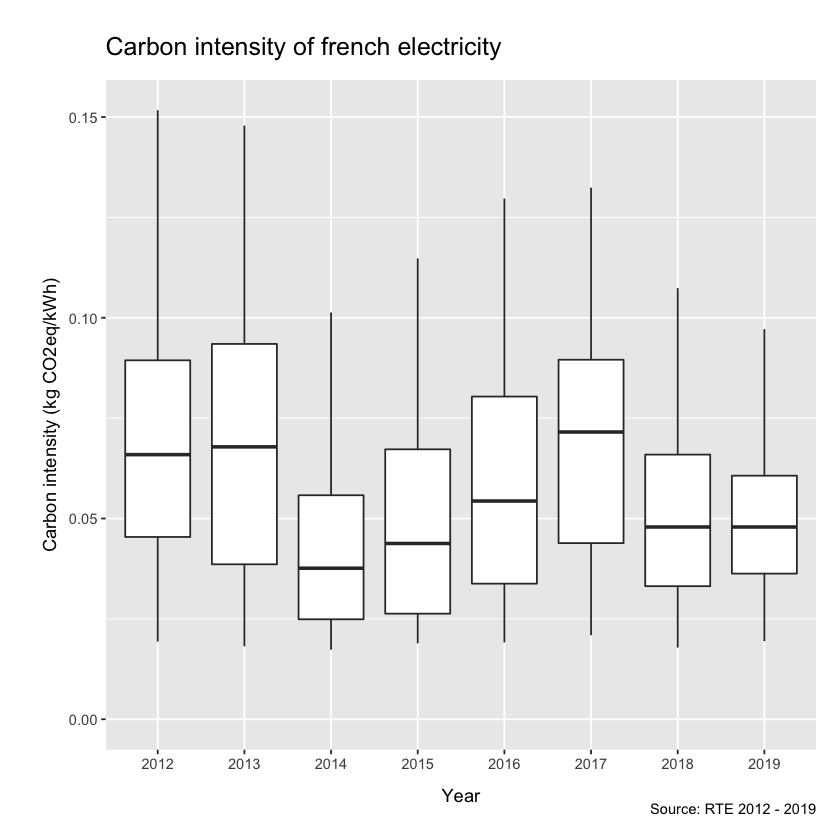

In [26]:
data  = data %>% add_co2_kg()
ggplot(data, aes(x = paste(year), y = co2_kg_kwh)) +
    geom_boxplot(outlier.shape = NA) + 
    scale_y_continuous(limits = c(0, NA)) +
    labs(
        title = 'Carbon intensity of french electricity',
        x = 'Year',
        y = 'Carbon intensity (kg CO2eq/kWh)',
        caption = 'Source: RTE 2012 - 2019'
    ) + 
    ggsave('./figures/carbon_intensity_by_year.png', width = unit(10, 'cm'))